    In this notebook, we will give a thorough overview of training a convolutional neural network consisting of two perceptron layers and visualizing the resulting model with t-SNE
   

In [1]:
import sys
sys.path

['',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python27.zip',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/plat-linux2',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/lib-tk',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/lib-old',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/lib-dynload',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/site-packages',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/site-packages/setuptools-21.2.1-py2.7.egg',
 '/home/souloist/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/extensions',
 '/home/souloist/.ipython']

In [2]:
%matplotlib inline
import tensorflow as tf
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


Next we import the MNIST data files we are going to be classifying. This database contains images of thousands of handwritten digits, and their proper labels. 


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz



The next three blocks of code define the neural network we will be training to recognize the handwritten digits.
Our steps will be:
* define a Tensorflow session 
* define the neural network. 

We will be using the standard LeNet model described in the Tensorflow tutorials. However, there is one important difference between this model however and the example model provided by Google: Here we compute a final fully connected layer 'h_fc2' separate from the softmax layer. 

In [4]:
sess = tf.Session()

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [6]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

x_image = tf.reshape(x, [-1,28,28,1])


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y_conv=tf.nn.softmax(h_fc2)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

The below block of code describes the actual training process, where we establish the optimizatin method, and the loop for training the network. We diverge again from the stock model by creating an empty list called 'finalRepresentation' and then filling that list with the 'h_fc2' output every 100 training iterations. By doing this, we are getting arrays containing the current representation of the network on the dataset. Once the training process is complete, we should expect an accuracy of around 94% (which is a 2-3% increase from just a single layer softmax layer).

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess.run(tf.initialize_all_variables())
finalRepresentations = []
for i in range(500):
    batch = mnist.train.next_batch(50)
    if (i%100 == 0):
        train_accuracy = accuracy.eval(session=sess,feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        finalRepresentations.append(h_fc2.eval(session=sess, feed_dict={x:mnist.test.images, keep_prob:1.0}))

    train_step.run(session=sess,feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(session=sess,feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.12


Turns out the above code made my mac cry. welp

Once the network has been trained, we need to get the labels for visualizing the data. The provided MNIST dataset uses one-hot encoding for the labels, but we in order to visualize, we need a 1D array, so we convert them back to that format.

In [8]:
testY = np.argmax(mnist.test.labels,1)

Along with looking at how well the network can represent examples, we can also use t-SNE to visualize how the network thinks of each of the classes. Here we get the weights of the final layer in order to visualize that below.

In [9]:
finalWs = W_fc2.eval(session=sess)

Google thankfully gives us an example of how to visualize the data with t-SNE by plotting it to a graph.

In [10]:
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(20, 20))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

Here is the code to generate our first t-SNE visualization of what the network has learned. t-SNE is a technique to reduce high-dimensional spaces into lower dimensional spaces so that they can be more easily visualized or dealt with by humans. We are going to visualize the final weights in order to give us an intuition of how the network is representing the ten different digit classes. The weight vector is 1024x10 dimensional, and we will be reducing it to a 10x2.

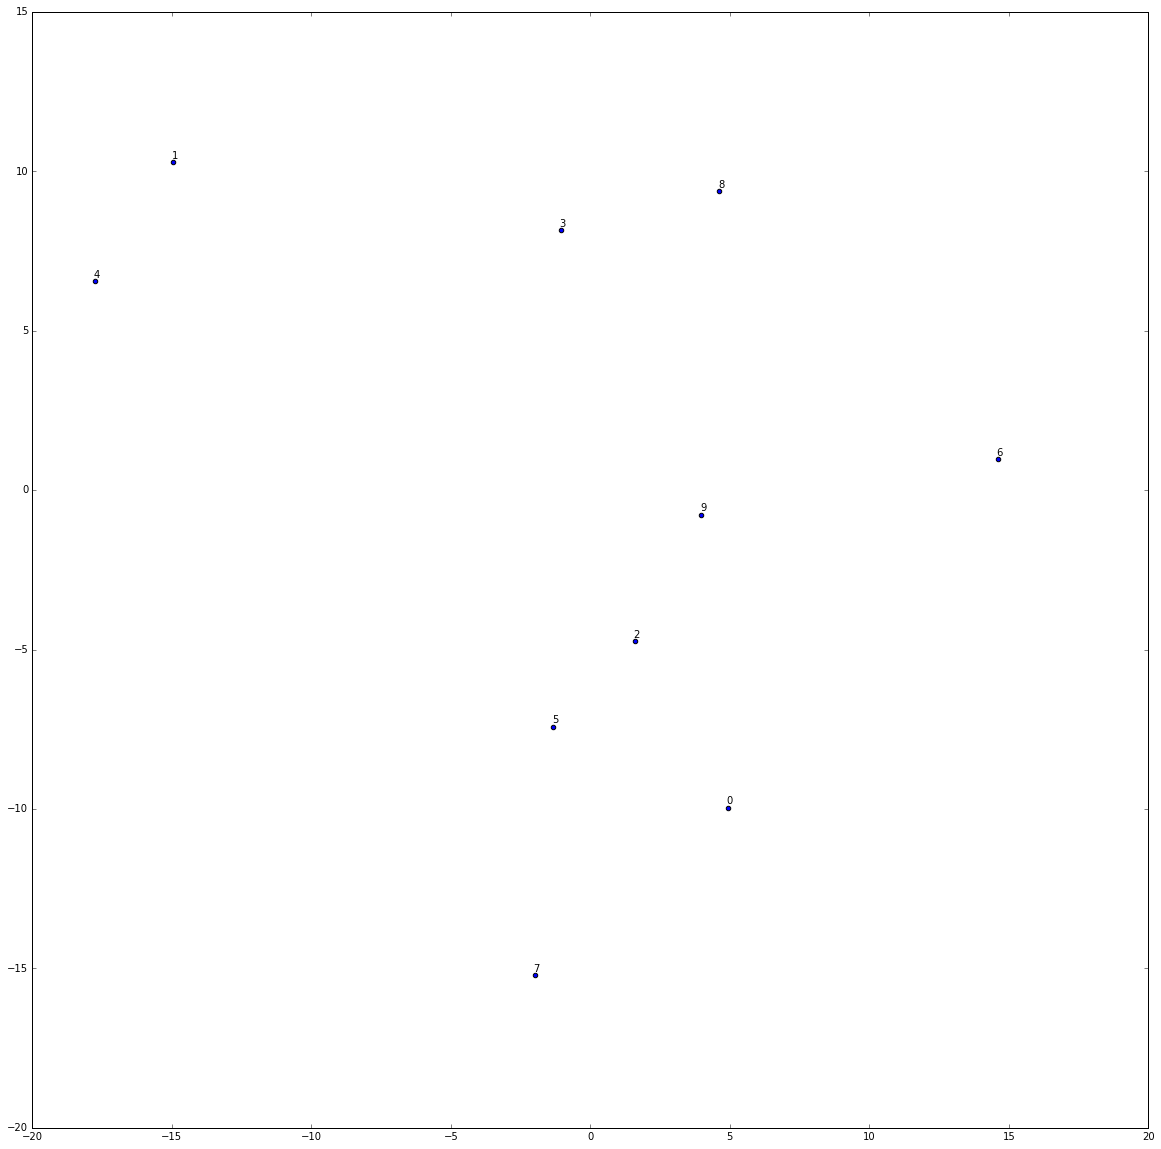

In [11]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 6
lowDWeights = tsne.fit_transform(finalWs)
labels = ['0','1','2','3','4','5','6','7','8','9']
plot_with_labels(lowDWeights, labels)


Now we are going to look at how the network's representation of actual test examples changes over time. We are going to be looking at the first 2000 test examples, at each of the checkpoints we captured in 'finalRepresentation.' This code will perform t-SNE dimensionality rediction on each of the arrays, and give us a graph in 2D of the representation. With this we can see how our network is able to better separate it's representations of different classes with more training time. The representation starts off fuzzy, with no clear boundaires between classes, but by the end of training, the network is able to represent them as most discreet groups in the 2D space.

In [ ]:
iters = 0
for i in finalRepresentations:
    tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
    plot_only = 2000
    lowDWeights = tsne.fit_transform(i[0:plot_only,:])
    labels = testY[0:plot_only]
    plot_with_labels(lowDWeights, labels, str(iters*100)+'.png')
    iters+=1